# Generating prediction models for bicycle accidents 2005-2020

### Introduction

The goal of this notebook is to find models that are suited for our use case, and try to improve their performance by testing different sets of parameters, reducing & resampling data.

### Import Libraries & packages

In [27]:
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency
import statsmodels.api as sm
from statsmodels.formula.api import ols

from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.metrics import mean_squared_error

from sklearn.model_selection import GridSearchCV, StratifiedShuffleSplit, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LassoCV

import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from timeit import default_timer as timer
from datetime import timedelta
from joblib import dump, load

### Import filtered dataset for bicycle accidents 2005-2020

In [3]:
df= pd.read_csv('data/bicycle_accidents_05_20_filtered.csv',sep=';', squeeze=True)
df

,grav,sexe,an,mois,jour,hrmn,lum,agg,int,atm,catr,circ,nbv,vosp,plan,surf,infra,situ,age
0,4,1,2005,1,13,19:45,5,2,1,1,3,2,2,0,1,1,0,1,59
1,3,1,2005,1,19,10:45,1,1,1,7,3,2,2,0,3,1,0,1,21
2,4,1,2005,1,26,13:15,1,1,9,1,3,2,2,0,1,1,0,1,72
3,3,2,2005,1,3,13:30,1,2,1,1,3,2,2,0,2,1,0,1,52
4,4,1,2005,1,29,18:30,3,1,1,1,3,2,2,0,1,1,0,1,75
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74922,3,2,2020,11,30,14:25,1,2,1,1,7,2,4,1,1,1,0,5,61
74923,4,2,2020,11,30,17:38,1,2,1,1,4,2,2,0,1,1,0,1,67
74924,4,1,2020,12,1,11:11,1,2,3,1,4,2,2,0,1,1,0,1,67
74925,4,2,2020,12,1,13:30,1,2,4,2,4,2,2,0,3,2,0,8,61


### Define the target variable and the features

In [4]:
#selecting explanatory features
data= df.drop(['grav', 'an', 'mois', 'jour', 'hrmn'],1)

#selecting target variable
target= df['grav']

In [5]:
#Display the count of unique values of each feature:
data.nunique()

sexe      2
lum       5
agg       2
int      10
atm       9
catr      8
circ      5
nbv       4
vosp      4
plan      5
surf      9
infra     2
situ      8
age      99
dtype: int64

***

### Analyse correlation between features
#### Analyse correlation between categorical features

- All the features in data are categorical, exept for 'age'. To study dependency between categorical features we use the  Chi-Square test,
if the p-value is less then 5% we reject the hypothesis of independence.

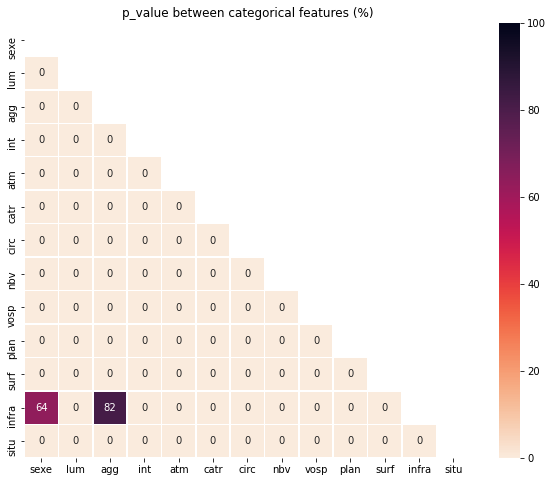

In [6]:
#Categorical features of data:
cat_features= data.columns.tolist()
cat_features.remove('age')

#create a matrix for p-values between each two categorial features
pvalueM = pd.DataFrame(index=cat_features, columns=cat_features)

for col1 in cat_features:
    for col2 in cat_features:
        table= pd.crosstab(data[col1] , data[col2])
        p_value= chi2_contingency( table)[1]
        pvalueM.loc[ col1, col2 ]= round(p_value*100 ,2)

mask= np.triu(np.ones_like(pvalueM, dtype=bool))
pvalueM = pvalueM.astype('int64')
plt.figure(figsize=(10, 8) )
cmap= sns.diverging_palette(220, 20, as_cmap=False)
sns.heatmap(pvalueM , annot=True, mask=mask,  cmap="rocket_r", vmin=0, vmax=100, linewidths=.5) 
plt.title('p_value between categorical features (%)');

The results of the p-value of the Chi-square test is 0 for almost all the values wich means they are strongly associated. This result doesn't seem to be logical, knowing that a lot of these features are not correlated from a logical point of view, like gender ('sexe) and atmosphere ('atm'). Also, the p-value of a weak association in a large samples size may also result in p = 0.

- To analyse coorelation between the categorical features we will use another measure: V-Cramer.

In [7]:
#Define V-Cramer function:
def cramers_corrected_stat(confusion_matrix):
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))    
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min( (kcorr-1), (rcorr-1)))


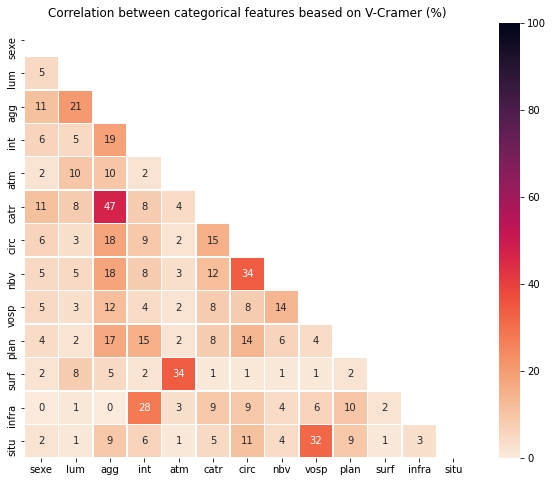

In [8]:
#Create a matrix for V_Cramer values between each two categorial features:
corrM= pd.DataFrame(index=cat_features, columns=cat_features)

for col1 in cat_features:
    for col2 in cat_features:
        corrM.loc[col1, col2] = round(cramers_corrected_stat(pd.crosstab(df[col1], df[col2])) * 100 ,2)

mask= np.triu(np.ones_like(corrM, dtype=bool))
corrM = corrM.astype('int64')
plt.figure(figsize=(10, 8))
sns.heatmap(corrM , annot=True, mask=mask, cmap='rocket_r' , vmin=0, vmax=100, linewidths=.5)
plt.title('Correlation between categorical features beased on V-Cramer (%)');

The V-Cramer between some features is above 30%, wich is a good score but not enough to prove a stong correlation between two variables.

#### Analyse correlation between categorical features and numerical feature

 In the features we have, there's one numerical feature: 'age'. The rest of the features are categorical.
To study correlation between 'age' and the rest of the features, we use the ANOVA (Analysis of Variance) test.

In [9]:
#create a string assembling categorical features in the forme of 'feature1+feature2+...'
features_string='' 
for col in cat_features:
    features_string= col+ '+' + features_string
features_string = features_string[:-1]

#create a string assembling categorical features in the forme of 'feature1+feature2+...'
features_string='' 
for col in cat_features:
    features_string= col+ '+' + features_string
features_string = features_string[:-1]

#Create a table for the result of ANOVA between the numerical feature 'age' and each one of the categorical features
anova_pvalues= pd.DataFrame(columns=cat_features, index=['corr_with_age_(%)'])

for col in cat_features:
    #Treatment of the pasty library will apply a dummy coding for categorical variable inside smf ols (it's optional)
    anova = ols(formula=f'age ~ C({col},Treatment)', data=data).fit()  
    table = sm.stats.anova_lm(anova, typ=2)
    anova_pvalues.loc['corr_with_age_(%)', col] = table['PR(>F)'][0]*100

#print(anova.summary())
anova_pvalues

,sexe,lum,agg,int,atm,catr,circ,nbv,vosp,plan,surf,infra,situ
corr_with_age_(%),0.003145,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


We can see the results of the ANOVA p-value (Prob F-statistic) between 'age' and each categorical variable are under 5%. Wich means there's a significant relationship between 'age' and each variable. 
This resut doesn't seem correct from a logical point of view, for exemple there can't be no relation between the factor of age and the infrastructure works ('infra).


From a mathematical point of view, this result is maybe due to the variable 'age' having a small number of unique values (99), and thus should not be considered a continuous variable. 
In the next step we will see if we can transform 'age' into a categorical variable.

#### Analyse 'age' feature

In this part we will analyse the 'age' feature to see if we shall transform it into a categorical variable.

- The first graph is showing the distribution of accidents by age. 

In [10]:
dx= df.copy()
dx.grav.replace([1,2,3,4], ['unharmed','killed','hospitalized','slight injuries'], inplace=True)

dx.grav.replace([1,2,3,4], ['unharmed','killed','hospitalized','slight injuries'], inplace=True)
dx = dx.groupby(['grav', 'age']).agg({'sexe': 'count'}).reset_index()
dx['percentage'] = dx.groupby('age')['sexe'].apply(lambda x: round(100*x/np.sum(x),2 )) 

fig1 = px.bar(dx, x="age", y="sexe", text="sexe", color="grav" ,
    template="plotly_dark",
    color_discrete_sequence= ["greenyellow", "crimson", "gold", "peachpuff"],
    labels={ 'sexe': 'victims count', 'grav':'severity'},
    category_orders={'grav':['unharmed','killed','hospitalized','slight injuries']}, barmode='relative'
    )

fig1.update_layout(width=1100, height=500,xaxis_title_text='Age' , yaxis_title_text='Victims count',
    title='Bicycle accidents by age 2005-2020',
    title_x=.5
 )
fig1.update_traces(textposition='inside', opacity=0.8 , visible=True)
fig1.show()

- This graph is showing a big number of accidents between the age of 13 & 23, after that the number is stable until it raches the age of 60 when it starts to decrease. This mean we can create three categories for age. But it will be also good if we define our categories based on the relationship with the target feature: severity of accidents. 

    To do this, we plot another graph for the distribution of accidents by age in accordance with the percentage of mortality.

In [11]:
fig2 = px.bar(dx, x="age", y="percentage", text="percentage", color="grav" ,
    template="plotly_dark",
    color_discrete_sequence= ["greenyellow", "crimson", "gold", "peachpuff"],
    labels={ 'sexe': 'victims count', 'grav':'severity'},
    category_orders={'grav':['unharmed','killed','hospitalized','slight injuries']}
    )

fig2.update_layout(width=1100, height=500,xaxis_title_text='Age' , yaxis_title_text='Victims by severity (%)',
    title='Bicycle accidents Mortality by age 2005-2020',
    title_x=.5
 )
fig2.update_traces(textposition='inside', opacity=0.8 , visible=True)
fig2.show()

(You can  select wich lever of severity to display)
- The graph below is showing that the mortalily of accident is at it lowest between the age of 20 & 40.
- The mortality of victims under 20 is slightly higher, since the the victims between 13 & 20 have the highest number of accidents we give them their own category.
- The mortality is getting much higher for people over 40 years old, and it keeps going up exponentially. Since the number of accidents is getting lower after 60, we divide this category into two subcategories : first one between 40 and 60, and the second for people over 60.

So the categories for 'age' are : 
- 1 : age < 13
- 2 : 13=< age =<20
- 3 : 20 < age =< 40
- 4 : 40 < age =< 60
- 5 : 60 < age 


In [12]:
#We cut the 'age' features into the 5 categories above:

data['age']= pd.cut(data.age, bins=[0,12,20,40,60,99], labels=[1,2,3,4,5] )

#save a copy for original data
data_original= data.copy()

### Preprocessing : Encoding and splitting data

Now that the values of our features and their type is defined (all features are categorical), we need to encode our data before doing any modeling. We will use One-Hot encoding. Then we will split our data to trainset and testset.

In [13]:
#Transform all categorical variables to 'category' type
data= data.astype('category')
# Dummy encoding:
data= pd.get_dummies(data)

In [14]:
#Split to train and test sets:
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size= .2, random_state= 42, shuffle=True )

### Features selection

In this part we will try to sort out features with higher importance. In order to validate our choice it has been tested and compared with original data using different values.
Note that we have tested SelectKBEst & VarianceThreshold from scikit-learn, they gave us same results. We kept the first selector.


The table below contains the variance of each dummy, it reflects the value count for each category, the smaller it's the smaller the variance

In [15]:
var_df= pd.DataFrame({ 'feature':X_train.columns.tolist() , 'variance':X_train.var(axis=0).tolist()}).sort_values(by='variance')
var_df['variance']=var_df.variance*100
var_df.head(20)

,feature,variance
9,int_0,0.000000
57,surf_4,0.011677
59,surf_6,0.018348
56,surf_3,0.063357
58,surf_5,0.075019
61,surf_8,0.080016
17,int_8,0.100000
28,catr_1,0.103330
72,situ_8,0.124969
60,surf_7,0.144934


In [16]:
#This value is chosen after testing diffrent k values on DSClassifier
# chi2 score is suited for testing score for categorial variables:
select= SelectKBest(score_func=chi2, k=60 )

X_train_reduced = select.fit_transform(X_train,y_train)
X_test_reduced = select.transform(X_test)

print(data.columns[select.get_support().tolist()])
#pd.DataFrame( X_train_reduced, columns=data.columns[select.get_support().tolist()])

Index(['sexe_1', 'sexe_2', 'lum_1', 'lum_2', 'lum_3', 'lum_5', 'agg_1',
       'agg_2', 'int_1', 'int_2', 'int_3', 'int_4', 'int_5', 'int_6', 'int_7',
       'int_8', 'int_9', 'atm_2', 'atm_5', 'atm_6', 'atm_7', 'catr_1',
       'catr_2', 'catr_3', 'catr_4', 'catr_9', 'circ_0', 'circ_1', 'circ_2',
       'circ_3', 'nbv_1', 'nbv_2', 'nbv_3', 'nbv_4', 'vosp_0', 'vosp_1',
       'vosp_2', 'vosp_3', 'plan_0', 'plan_1', 'plan_2', 'plan_3', 'plan_4',
       'surf_2', 'surf_6', 'surf_9', 'infra_0', 'infra_1', 'situ_0', 'situ_1',
       'situ_3', 'situ_4', 'situ_5', 'situ_6', 'situ_8', 'age_1', 'age_2',
       'age_3', 'age_4', 'age_5'],
      dtype='object')


### Model Selection

In this part we will test some supervised prediction model for classification on our dataset, using cross validation. In order to find the best parameters set for each model, we use the GridSearchCV from scikit-learn package.

First we are going to test simple models like : DecisionTree, KNearestNeighbors, SVM, Lasso. And then we test test with ensemble models: RandomForestClassifier. Testing will be done on normal data and reduced data with SelektKBest.

In order to improve results, we tried Over and UnderSampling but they had made score lower.

In [17]:
#Define the cross-validation splitting method
CV= StratifiedShuffleSplit(n_splits= 10, test_size=.2, random_state= 42 )

In [18]:
estimators={}
grids= {}
params= {}

#Define RMS function:
def RMSE(y_predict, y_reel):
    rmse= np.sqrt(mean_squared_error(y_predict, y_reel))
    return rmse

**A. Non reduced data**

**1. Decision Tree**

In [19]:
start = timer()
#Define estimator
estimators['DS']= DecisionTreeClassifier()

#Define parmameters for DS grid:
params['DS']= { 
    'criterion':['entropy','gini'], 
    'max_depth':[3,4,5,6,7],
    'min_samples_leaf':[1,2,3,4,5]
}
#Define DS model grid:
grids['DS'] = GridSearchCV(estimator= estimators['DS'], param_grid= params['DS'], n_jobs=-1, cv=CV)
grids['DS'].fit(X_train, y_train)

#testing model and getting best parameters:
y_pred_train = grids['DS'].best_estimator_.predict(X_train)
y_pred_test = grids['DS'].best_estimator_.predict(X_test)

print("Score R2 on trainset      : ", grids['DS'].best_estimator_.score(X_train, y_train))
print("Score R2 on testset       : ", grids['DS'].best_estimator_.score(X_test, y_test))

print("Score of RMSE on trainset : ", RMSE(y_train, y_pred_train))
print("Score of RMSE on testset  : ", RMSE(y_test,y_pred_test))

print("Best parameters           : ", grids['DS'].best_params_)
end = timer()
print("Execution time: ", timedelta(seconds=end-start))

#save models
dump(grids['DS'] , 'DS_Grid')

Score R2 on trainset      :  0.6497389099280959
Score R2 on testset       :  0.6466702255438409
Score of RMSE on trainset :  0.9253965381249061
Score of RMSE on testset  :  0.9224573336277073
Best parameters           :  {'criterion': 'gini', 'max_depth': 6, 'min_samples_leaf': 3}
Execution time:  0:00:30.563697


['DS_Grid']

**2. KNearestNeighbores**

In [58]:
start = timer()
#Define estimator
estimators['KNN']= KNeighborsClassifier()

#Define parameters for KNN grid:
params['KNN']= { 
    'n_neighbors':np.arange(1,7),
    'metric':['minkowski','manhattan','euclidean'],
    'leaf_size':[30,40,50]
}
#Define KNN model grid:
grids['KNN'] = GridSearchCV(estimator= estimators['KNN'], param_grid= params['KNN'], n_jobs=-1, cv=CV)
grids['KNN'].fit(X_train, y_train)

#testing model and getting best parameters:
y_pred_train = grids['KNN'].best_estimator_.predict(X_train)
y_pred_test = grids['KNN'].best_estimator_.predict(X_test)

print("Score R2 on trainset      : ", grids['KNN'].best_estimator_.score(X_train, y_train))
print("Score R2 on testset       : ", grids['KNN'].best_estimator_.score(X_test, y_test))

print("Score of RMSE on trainset : ", RMSE(y_train, y_pred_train))
print("Score of RMSE on testset  : ", RMSE(y_test,y_pred_test))

print("Best parameters           : ", grids['KNN'].best_params_)
end = timer()
print("Execution time: ", timedelta(seconds=end-start))

#save model
dump(grids['KNN'], 'KNN_Grid')

Score R2 on trainset      :  0.6514906324552476
Score R2 on testset       :  0.5912184705725344
Score of RMSE on trainset :  0.9585249730472455
Score of RMSE on testset  :  1.015823034132535
Best parameters           :  {'leaf_size': 30, 'metric': 'minkowski', 'n_neighbors': 6}
Execution time:  1:14:56.331716



**3. SVM**

In [62]:
start = timer()
#Define estimator
estimators['SVM']= SVC()

#Define parameters for SVM grid:
params['SVM']= { 
    'C':[.1, 1,10],
    'kernel':['poly', 'rbf']
}
#Define SVM model grid:
grids['SVM'] = GridSearchCV(estimator= estimators['SVM'], param_grid= params['SVM'], n_jobs=-1, cv=CV)
grids['SVM'].fit(X_train, y_train)

#testing model and getting best parameters:
y_pred_train = grids['SVM'].best_estimator_.predict(X_train)
y_pred_test = grids['SVM'].best_estimator_.predict(X_test)

print("Score R2 on trainset      : ", grids['SVM'].best_estimator_.score(X_train, y_train))
print("Score R2 on testset       : ", grids['SVM'].best_estimator_.score(X_test, y_test))

print("Score of RMSE on trainset : ", RMSE(y_train, y_pred_train))
print("Score of RMSE on testset  : ", RMSE(y_test,y_pred_test))

print("Best parameters           : ", grids['SVM'].best_params_)
end = timer()
print("Execution time: ", timedelta(seconds=end-start))

#save models
dump(grids['SVM'] , 'SVM_Grid')

* After 400min execution was still running, so I had to interrupt

**4. Lasso**

In [20]:
start = timer()

#Define Lasso model:
model_lasso= LassoCV(alphas=[1e-6, 1e-5, 1e-4, 2e-4, 0.001, 0.1,1,10], n_jobs= -1, max_iter=1000, cv=CV )
model_lasso.fit(X_train, y_train )

#testing model:
y_pred_train = model_lasso.predict(X_train)
y_pred_test = model_lasso.predict(X_test)
model_lasso.get_params()

print("Score R2 on trainset      : ", model_lasso.score(X_train, y_train))
print("Score R2 on testset       : ", model_lasso.score(X_test, y_test))

print("Score of RMSE on trainset : ", RMSE(y_train, y_pred_train))
print("Score of RMSE on testset  : ", RMSE(y_test,y_pred_test))

print("Best parameters           : ", model_lasso.alpha_)
end = timer()
print("Execution time: ", timedelta(seconds=end-start))

#save models
dump(model_lasso , 'Lasso')

Score R2 on trainset      :  0.06920928210312038
Score R2 on testset       :  0.06241237729739091
Score of RMSE on trainset :  0.8009217965126396
Score of RMSE on testset  :  0.7969710153369441
Best parameters           :  0.0001
Execution time:  0:00:01.530534


['Lasso']

**5. RandomForest**

In [11]:
start = timer()
#Define estimator
estimators['RF']= RandomForestClassifier(n_jobs=-1)

#Define parameters for RF grid:
params['RF']= { 
    'n_estimators':[1000, 1500,2000],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth':['None',5,10]
}
#Define RF model grid:
grids['RF'] = GridSearchCV(estimator= estimators['RF'], param_grid= params['RF'], n_jobs=-1, cv=CV)
grids['RF'].fit(X_train, y_train)

#testing model and getting best parameters:
y_pred_train = grids['RF'].best_estimator_.predict(X_train)
y_pred_test = grids['RF'].best_estimator_.predict(X_test)

print("Score R2 on trainset      : ", grids['RF'].best_estimator_.score(X_train, y_train))
print("Score R2 on testset       : ", grids['RF'].best_estimator_.score(X_test, y_test))

print("Score of RMSE on trainset : ", RMSE(y_train, y_pred_train))
print("Score of RMSE on testset  : ", RMSE(y_test,y_pred_test))

print("Best parameters           : ", grids['RF'].best_params_)
end = timer()
print("Execution time: ", timedelta(seconds=end-start))

#save models
dump(grids['RF'] , 'RF_Grid')

KeyboardInterrupt: 

**B. Reduced data**

In [21]:
estimators={}
grids= {}
params= {}

**1. Decision Tree: reduced data:**

In [22]:
#Define estimator
estimators['DS']= DecisionTreeClassifier()

#Define parmameters for DS grid:
params['DS']= { 
    'criterion':['entropy','gini'], 
    'max_depth':[3,4,5,6,7],
    'min_samples_leaf':[1,2,3,4,5]
}
#Define DS model grid:
grids['DS'] = GridSearchCV(estimator= estimators['DS'], param_grid= params['DS'], n_jobs=-1, cv=CV)
grids['DS'].fit(X_train_reduced, y_train)

#testing model and getting best parameters:
y_pred_train = grids['DS'].best_estimator_.predict(X_train_reduced)
y_pred_test = grids['DS'].best_estimator_.predict(X_test_reduced)

print("Score R2 on trainset      : ", grids['DS'].best_estimator_.score(X_train_reduced, y_train))
print("Score R2 on testset       : ", grids['DS'].best_estimator_.score(X_test_reduced, y_test))

print("Score of RMSE on trainset : ", RMSE(y_train, y_pred_train))
print("Score of RMSE on testset  : ", RMSE(y_test,y_pred_test))

print("Best parameters           : ", grids['DS'].best_params_)
end = timer()
print("Execution time: ", timedelta(seconds=end-start))

#save models
dump(grids['DS'] , 'DS_Grid_reduced')

Score R2 on trainset      :  0.6499224237166548
Score R2 on testset       :  0.6476711597490992
Score of RMSE on trainset :  0.9249727825207963
Score of RMSE on testset  :  0.9217336672939722
Best parameters           :  {'criterion': 'gini', 'max_depth': 6, 'min_samples_leaf': 1}
Execution time:  0:01:26.880507


['DS_Grid_reduced']

**2. Lasso**

In [23]:
start = timer()

#Define Lasso model:
model_lasso= LassoCV(alphas=[1e-6, 1e-5, 1e-4, 2e-4, 0.001, 0.1,1,10], n_jobs= -1, max_iter=1000, cv=CV )
model_lasso.fit(X_train_reduced, y_train )

#testing model:
y_pred_train = model_lasso.predict(X_train_reduced)
y_pred_test = model_lasso.predict(X_test_reduced)
model_lasso.get_params()

print("Score R2 on trainset      : ", model_lasso.score(X_train_reduced, y_train))
print("Score R2 on testset       : ", model_lasso.score(X_test_reduced, y_test))

print("Score of RMSE on trainset : ", RMSE(y_train, y_pred_train))
print("Score of RMSE on testset  : ", RMSE(y_test,y_pred_test))

print("Best parameters           : ", model_lasso.alpha_)
end = timer()
print("Execution time: ", timedelta(seconds=end-start))

#save models
dump(model_lasso , 'Lasso_reduced')

Score R2 on trainset      :  0.06910117647295932
Score R2 on testset       :  0.06246003878168849
Score of RMSE on trainset :  0.8009683062381603
Score of RMSE on testset  :  0.7969507584012949
Best parameters           :  0.0001
Execution time:  0:00:01.381865


['Lasso_reduced']

* Lasso has a very low result, this is normal since it's a model for continuous variables


**3. SVM**

In [ ]:
start = timer()
#Define estimator
estimators['SVM']= SVC()

#Define parameters for SVM grid:
params['SVM']= { 
    'C':[.1, 1,10,100],
    'kernel':['linear', 'poly', 'rbf']
}
#Define SVM model grid:
grids['SVM'] = GridSearchCV(estimator= estimators['SVM'], param_grid= params['SVM'], n_jobs=-1, cv=CV)
grids['SVM'].fit(X_train_reduced, y_train)

#testing model and getting best parameters:
y_pred_train = grids['SVM'].best_estimator_.predict(X_train_reduced)
y_pred_test = grids['SVM'].best_estimator_.predict(X_test_reduced)

print("Score R2 on trainset      : ", grids['SVM'].best_estimator_.score(X_train_reduced, y_train))
print("Score R2 on testset       : ", grids['SVM'].best_estimator_.score(X_test_reduced, y_test))

print("Score of RMSE on trainset : ", RMSE(y_train, y_pred_train))
print("Score of RMSE on testset  : ", RMSE(y_test,y_pred_test))

print("Best parameters           : ", grids['SVM'].best_params_)
end = timer()
print("Execution time: ", timedelta(seconds=end-start))

#save models
dump(grids['SVM'] , 'SVM_Grid_reduced')

* To have a look on the resulted models, please refer to the generated joblib files.

In [37]:
modelx= load('models/SVM_Grid_reduced')
print("Score R2 on trainset      : ", modelx.best_estimator_.score(X_train_reduced, y_train))
print("Score R2 on testset       : ", modelx.best_estimator_.score(X_test_reduced, y_test))

y_pred_train = modelx.best_estimator_.predict(X_train_reduced)
y_pred_test = modelx.best_estimator_.predict(X_test_reduced)
print("Score of RMSE on trainset : ", RMSE(y_train, y_pred_train))
print("Score of RMSE on testset  : ", RMSE(y_test,y_pred_test))
print("Best parameters           : ", modelx.best_params_)

C:\Users\WonderSSJ9\anaconda3\lib\site-packages\sklearn\base.py:310: UserWarning:

Trying to unpickle estimator SVC from version 0.24.2 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.

C:\Users\WonderSSJ9\anaconda3\lib\site-packages\sklearn\base.py:310: UserWarning:

Trying to unpickle estimator GridSearchCV from version 0.24.2 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.



Score R2 on trainset      :  0.6568792646102001
Score R2 on testset       :  0.6486053650073402
Score of RMSE on trainset :  0.9165111343832424
Score of RMSE on testset  :  0.9203571336370142
Best parameters           :  {'C': 1, 'kernel': 'poly'}


In [39]:
modely= load('models/RF_Grid')
print("Score R2 on trainset      : ", modely.best_estimator_.score(X_train, y_train))
print("Score R2 on testset       : ", modely.best_estimator_.score(X_test, y_test))
y_pred_train = modely.best_estimator_.predict(X_train)
y_pred_test = modely.best_estimator_.predict(X_test)
print("Score of RMSE on trainset : ", RMSE(y_train, y_pred_train))
print("Score of RMSE on testset  : ", RMSE(y_test,y_pred_test))
print("Best parameters           : ", modely.best_params_)

C:\Users\WonderSSJ9\anaconda3\lib\site-packages\sklearn\base.py:310: UserWarning:

Trying to unpickle estimator DecisionTreeClassifier from version 0.24.2 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.

C:\Users\WonderSSJ9\anaconda3\lib\site-packages\sklearn\base.py:310: UserWarning:

Trying to unpickle estimator RandomForestClassifier from version 0.24.2 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.

C:\Users\WonderSSJ9\anaconda3\lib\site-packages\sklearn\base.py:310: UserWarning:

Trying to unpickle estimator GridSearchCV from version 0.24.2 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.



Score R2 on trainset      :  0.6593650422915868
Score R2 on testset       :  0.6487388229013746
Score of RMSE on trainset :  0.9186928739537364
Score of RMSE on testset  :  0.9201395979711109
Best parameters           :  {'max_depth': 10, 'max_features': 'auto', 'n_estimators': 2000}


***

**This is a reproduction of the correlation heatmap between the categorical features after dummy encoding**

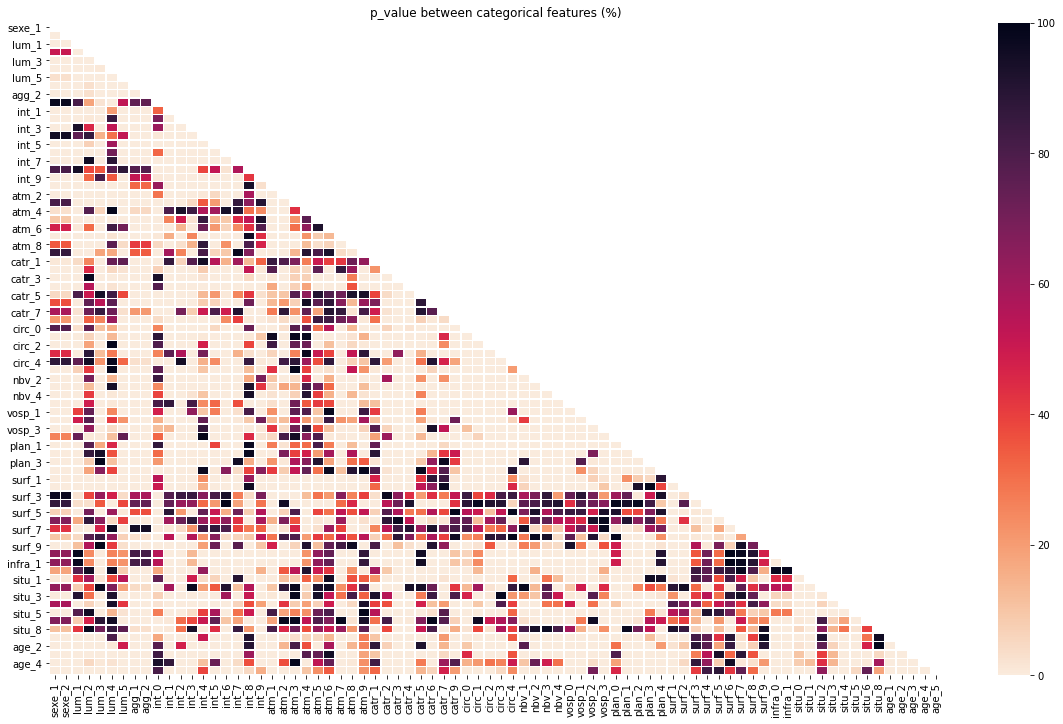

In [424]:
#Categorical features of data:
cat_features= data.columns.tolist()


#create a matrix for p-values between each two categorial features
pvalueM = pd.DataFrame(index=cat_features, columns=cat_features)

for col1 in cat_features:
    for col2 in cat_features:
        table= pd.crosstab(data[col1] , data[col2])
        p_value= chi2_contingency( table)[1]
        pvalueM.loc[ col1, col2 ]= round(p_value*100 ,2)

mask= np.triu(np.ones_like(pvalueM, dtype=bool))
pvalueM = pvalueM.astype('int64')
plt.figure(figsize=(20, 12) )
cmap= sns.diverging_palette(220, 20, as_cmap=False)
sns.heatmap(pvalueM , annot=False, mask=mask,  cmap="rocket_r", vmin=0, vmax=100, linewidths=.5) 
plt.title('p_value between categorical features (%)');